In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import gaussian, convolve2d, correlate
from scipy.fft import fft2, ifft2, fftshift
from skimage import io, img_as_ubyte, util, color
from skimage.metrics import peak_signal_noise_ratio

plt.style.use('dark_background')

In [2]:
# Scipy's version
def wiener(im, mysize=None, noise=None):
    """
    Perform a Wiener filter on an N-dimensional array.

    Apply a Wiener filter to the N-dimensional array `im`.

    Parameters
    ----------
    im : ndarray
        An N-dimensional array.
    mysize : int or array_like, optional
        A scalar or an N-length list giving the size of the Wiener filter
        window in each dimension.  Elements of mysize should be odd.
        If mysize is a scalar, then this scalar is used as the size
        in each dimension.
    noise : float, optional
        The noise-power to use. If None, then noise is estimated as the
        average of the local variance of the input.

    Returns
    -------
    out : ndarray
        Wiener filtered result with the same shape as `im`.

    Notes
    -----
    This implementation is similar to wiener2 in Matlab/Octave.
    For more details see [1]_
    """
    
    im = np.asarray(im)
    if mysize is None:
        mysize = [3] * im.ndim
    mysize = np.asarray(mysize)
    if mysize.shape == ():
        mysize = np.repeat(mysize.item(), im.ndim)

    # Estimate the local mean
    lMean = correlate(im, np.ones(mysize), 'same') / np.prod(mysize, axis=0)

    # Estimate the local variance
    lVar = (correlate(im ** 2, np.ones(mysize), 'same') /
            np.prod(mysize, axis=0) - lMean ** 2)

    # Estimate the noise power if needed.
    if noise is None:
        noise = np.mean(np.ravel(lVar), axis=0)

    res = (im - lMean)
    res *= (1 - noise / lVar)
    res += lMean
    out = np.where(lVar < noise, lMean, res)

    return out

In [3]:
# Le-Anh Tran's version
def add_gaussian_noise(img, sigma):
    gauss = np.random.normal(0, sigma, np.shape(img))
    gauss = gauss / np.max(np.abs(gauss))
    noisy_img = img + gauss
    noisy_img = np.clip(noisy_img, 0, 1)
    noisy_img[noisy_img < 0] = 0
    noisy_img[noisy_img > 255] = 255
    return noisy_img

def blur(img, kernel_size = 3):
    dummy = np.copy(img)
    h = np.eye(kernel_size) / kernel_size
    dummy = convolve2d(dummy, h, mode = 'same')
    return dummy

def gaussian_kernel(kernel_size = 3):
    h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)
    return h

def tran_wiener(img, kernel, K):
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = fft2(dummy)
    kernel = fft2(kernel, s = img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(ifft2(dummy))
    return dummy

In [4]:
# Our version
def wien(image, No=0.01):
    xdim, ydim = image.shape

    # Create LSI degradation model, need it to be phaseless
    hi = 3.5**(-2)
    h = np.zeros((xdim, ydim))
    xl = 4
    xh = xdim - xl + 2
    h[0:xl, 0:xl] = hi
    h[xh:xdim, 0:xl] = hi
    h[0:xl, xh:ydim] = hi
    h[xh:xdim, xh:ydim] = hi

    # Calculate power spectral density of input image
    PICT = fft2(image)
    Suu = np.abs(PICT)**2

    # Calculate power spectral density of the noise (assuming Gaussian noise with variance No)
    Snn = No * np.ones((xdim, ydim))

    # Calculate Fourier Transform of LSI Filter
    H = fft2(h, (xdim, ydim))
    H2 = np.abs(H)**2

    # Calculate thresholded 1/H
    HINV = np.copy(H)
    index = np.where(np.abs(H) < 0.2)
    hzeros = len(index[0])  # Return number of elements below threshold
    HINV[index] = 0

    # Calculate Wiener Filter
    G = HINV * (H2 * Suu) / ((H2 * Suu) + Snn)

    # Restore Image
    DPICT = fft2(image)
    RPICT = DPICT * G
    rpict = np.abs(ifft2(RPICT))
    
    # Normalize image to the range [-1, 1]
    max_val = np.max(rpict)
    min_val = np.min(rpict)
    rpict = (rpict - min_val) / (max_val - min_val) * 2 - 1

    return rpict

TODO : Add skimage wiener implementation for Vincent

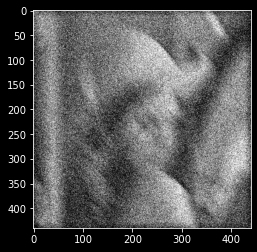

In [5]:
# Load greyscale image
original_image = io.imread('data/lena2.png')
original_image = color.rgb2gray(original_image)

# Blur it and add noise
blurred_img = blur(original_image, kernel_size=27)
sigma = 30
noisy_image = add_gaussian_noise(blurred_img, sigma=sigma)
# noisy_image = util.random_noise(original_image, mode='gaussian', var=0.3, mean=-0.3)

plt.imshow(noisy_image, cmap='gray')

In [6]:
scipy_image = wiener(noisy_image, mysize=3, noise=1.0)
tran_image = tran_wiener(noisy_image, gaussian_kernel(5), K=10)
our_image = wien(noisy_image, sigma**2)

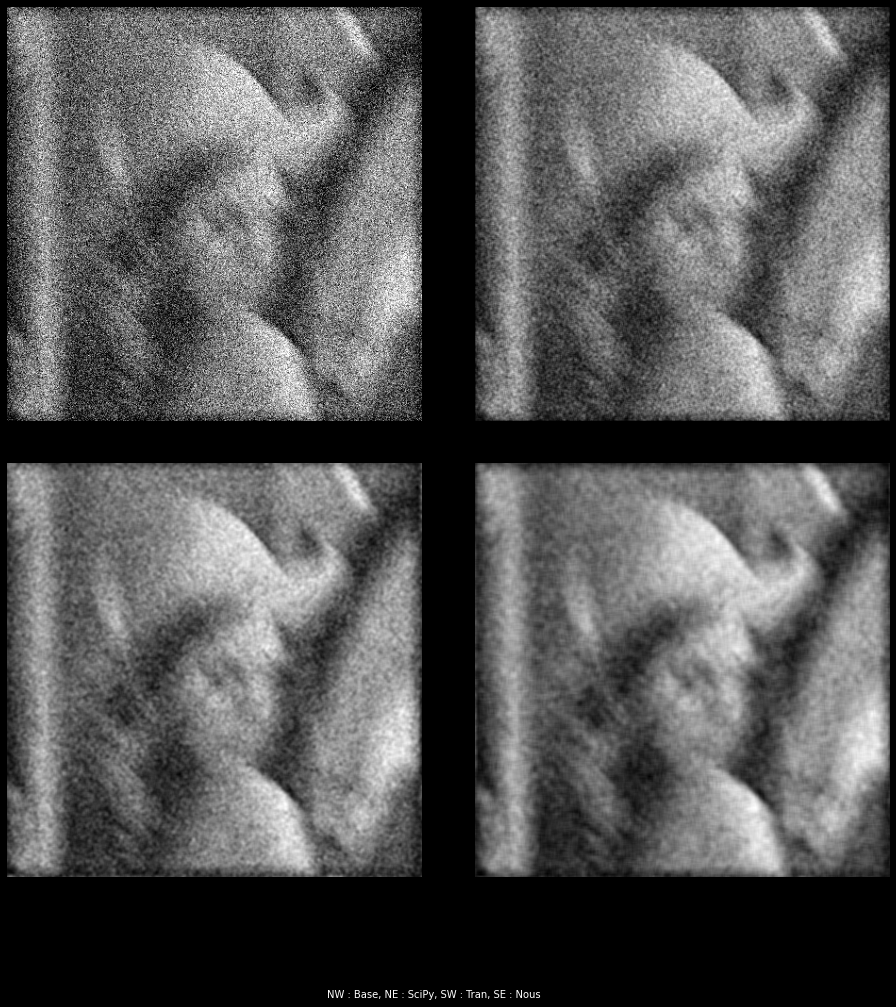

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

# Affichage de chaque image dans un sous-graphique
axs[0, 0].imshow(noisy_image, cmap='gray')
axs[0, 1].imshow(scipy_image, cmap='gray')
axs[1, 0].imshow(tran_image, cmap='gray')
axs[1, 1].imshow(our_image, cmap='gray')

# Supprimer les axes pour une meilleure apparence
for ax in axs.flatten():
    ax.axis('off')

fig.text(0.5, 0.02, 'NW : Base, NE : SciPy, SW : Tran, SE : Nous', ha='center', fontsize='medium')
# Affichage de la figure
plt.show()

In [8]:
original_image = img_as_ubyte(original_image)
scipy_image = img_as_ubyte(scipy_image)
tran_image = img_as_ubyte(tran_image)
our_image = img_as_ubyte(our_image)

psnr_value_scipy = peak_signal_noise_ratio(original_image, scipy_image)
psnr_value_tran = peak_signal_noise_ratio(original_image, tran_image)
psnr_value_our = peak_signal_noise_ratio(original_image, our_image)

print("PSNR from SciPy:", psnr_value_scipy)
print("PSNR from Tran:", psnr_value_tran)
print("PSNR from us:", psnr_value_our)

PSNR from SciPy: 17.92848821190128
PSNR from Tran: 6.859579901237217
PSNR from us: 8.440524888312178


In [9]:
# FIXME
"""
import numpy as np
import scipy.fftpack as fftpack
import scipy.ndimage as ndimage
from skimage.restoration import wiener
from skimage import io, color
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

def wien(name, xdim, No, blur):
    # Load and Plot image
    pict = io.imread(name)
    pict = color.rgb2gray(pict)

    plt.subplot(221)
    plt.imshow(pict, cmap='gray')
    txt = f"{name} before degradation"
    plt.title(txt)
    plt.axis('off')

    # Create LSI degradation model, need it to be phaseless
    hi = 3.5**(-2)
    h = np.zeros((xdim, xdim))
    xl = 4
    xh = xdim - xl + 2
    h[:xl, :xl] = hi
    h[xh:xdim, :xl] = hi
    h[:xl, xh:xdim] = hi
    h[xh:xdim, xh:xdim] = hi

    # Create Gaussian noise, mean = 0, variance comes from input (No)
    noise = np.sqrt(No) * np.random.randn(xdim, xdim)

    # Run image through LSI Filter and then add noise
    dpict = convolve2d(pict, h, mode='same') + noise

    plt.subplot(222)
    plt.imshow(dpict, cmap='gray')
    txt = f"{name} with additive Gaussian Noise (mean=0, var={No})"
    plt.title(txt)
    plt.axis('off')

    # Calculate MSE of degraded image
    error = dpict - pict
    sqerr = np.sum(error**2) / (xdim**2)
    DMSE = sqerr

    # Calculate power spectral density of input image
    PICT = fftpack.fft2(pict)
    Suu = np.abs(PICT)**2

    # Calculate power spectral density of the AGN
    NOISE = fftpack.fft2(noise)
    Snn = np.abs(NOISE)**2

    # Calculate Fourier Transform of LSI Filter
    H = fftpack.fft2(h, (xdim, xdim))
    H2 = np.abs(H)**2

    plt.subplot(223)
    plt.imshow(np.fft.fftshift(np.abs(H)), cmap='gray')
    txt = 'Frequency Spectra of blurring filter'
    plt.title(txt)
    plt.axis('off')

    # Calculate thresholded 1/H
    HINV = np.zeros_like(H)
    index = np.abs(H) < 0.2
    HINV[index] = 0
    HINV[~index] = 1 / H[~index]

    # Calculate Wiener Filter
    G = HINV * (H2 * Suu) / ((H2 * Suu) + Snn)

    # Restore Image
    DPICT = fftpack.fft2(dpict)
    RPICT = DPICT * G
    rpict = fftpack.ifft2(RPICT)

    plt.subplot(224)
    plt.imshow(np.abs(rpict), cmap='gray')
    txt = f"{name} restored using Wiener Filter, known h, Snn, Suu"
    plt.title(txt)
    plt.axis('off')

    # Calculate MSE of restored image
    error = np.abs(rpict) - pict
    sqerr = np.sum(error**2) / (xdim**2)
    RMSE = sqerr

    # Calculate MSE of restored image through Wiener filtering
    block = np.array([16, 16])
    block_arr = np.tile(block, (xdim // block[0], xdim // block[1]))
    wpict = wiener(dpict, block_arr, balance=0.1)

    error = np.abs(wpict) - pict
    sqerr = np.sum(error**2) / (xdim**2)
    WMSE = sqerr

    plt.show()

wien('input_image.jpg', 256, 0.1, None)"""

'\nimport numpy as np\nimport scipy.fftpack as fftpack\nimport scipy.ndimage as ndimage\nfrom skimage.restoration import wiener\nfrom skimage import io, color\nimport matplotlib.pyplot as plt\nfrom scipy.signal import convolve2d\n\ndef wien(name, xdim, No, blur):\n    # Load and Plot image\n    pict = io.imread(name)\n    pict = color.rgb2gray(pict)\n\n    plt.subplot(221)\n    plt.imshow(pict, cmap=\'gray\')\n    txt = f"{name} before degradation"\n    plt.title(txt)\n    plt.axis(\'off\')\n\n    # Create LSI degradation model, need it to be phaseless\n    hi = 3.5**(-2)\n    h = np.zeros((xdim, xdim))\n    xl = 4\n    xh = xdim - xl + 2\n    h[:xl, :xl] = hi\n    h[xh:xdim, :xl] = hi\n    h[:xl, xh:xdim] = hi\n    h[xh:xdim, xh:xdim] = hi\n\n    # Create Gaussian noise, mean = 0, variance comes from input (No)\n    noise = np.sqrt(No) * np.random.randn(xdim, xdim)\n\n    # Run image through LSI Filter and then add noise\n    dpict = convolve2d(pict, h, mode=\'same\') + noise\n\n    p